<a href="https://colab.research.google.com/github/Sahithi530/Sahithi_INFO5731_Fall2024/blob/main/Tummala_Sahithi_Exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [3]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 64.0 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Exploring the dataset

In [15]:
from google.colab import files
uploaded = files.upload()  # This will open a file picker
medium_articles = pd.read_csv('articles 3.csv')

Saving articles 3.csv to articles 3.csv


Total Number of unique authors : 182


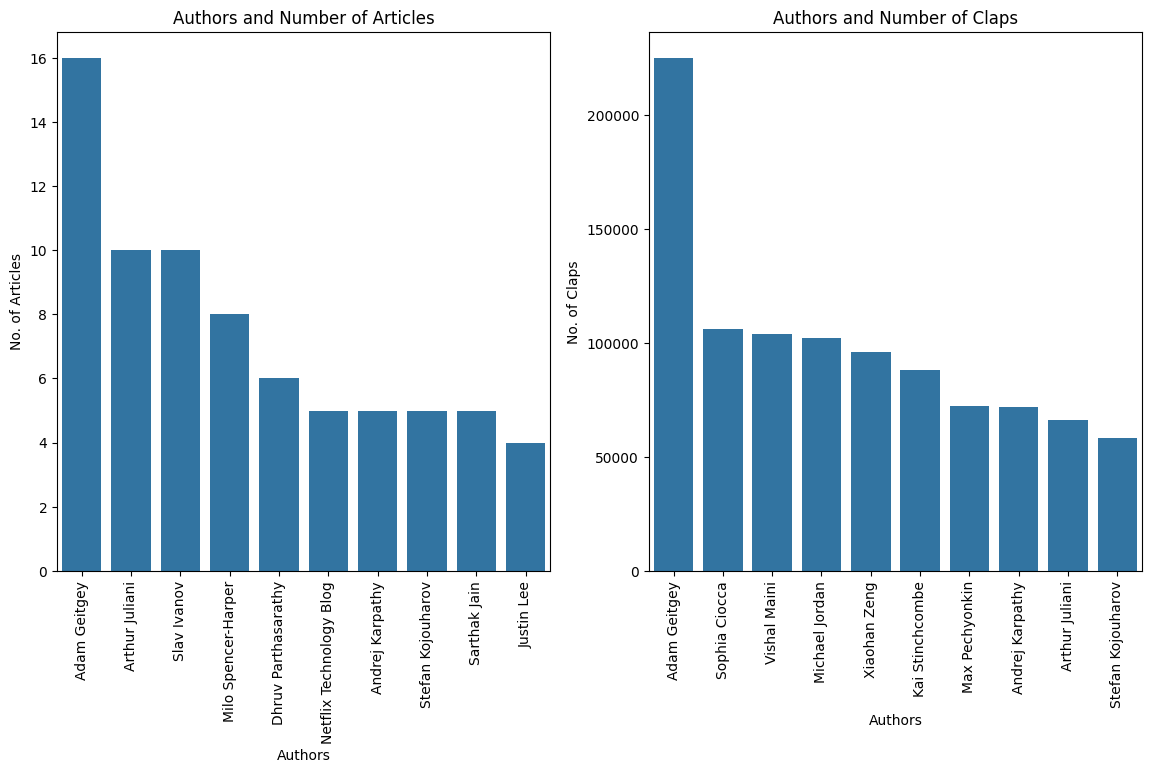

In [16]:
article_text = medium_articles.text
# visualise first article print few words from it
#print("First 1000 words in first article are : \n",article_text[0][:1000])

#total number of author
print(f"Total Number of unique authors : {len(medium_articles.author.unique())}")

#counting the articles of different authors
article_counts = dict()
for author in medium_articles.author:
    article_count = len(medium_articles[medium_articles["author"]==author])
    article_counts[author] = article_count

#sorting the article_counts on the basis of article count
article_counts = dict(sorted(article_counts.items(), key=lambda x: x[1], reverse=True))


#plot histogram of top 10 authors and their article counts
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
sns.barplot(x = list(article_counts.keys())[:10],y=list(article_counts.values())[:10])
plt.title("Authors and Number of Articles")
plt.xlabel("Authors")
plt.ylabel("No. of Articles")
plt.xticks(rotation = 90)



#counting the total number of claps for each author
def convert_to_num(clap_count):
    if "K" in clap_count:
        if "." in clap_count:
            clap_count = re.sub("\.","",clap_count[:-1])+"00"
        else:
            clap_count = clap_count[:-1]+"000"
    return(int(clap_count))

medium_articles.claps = medium_articles.claps.apply(convert_to_num)

#couting total number of claps for each author
clap_counts = dict()
for author in medium_articles.author:
    clap_count = medium_articles[medium_articles["author"]==author]["claps"]
    clap_counts[author] = sum(clap_count)

#sort clap_counts on the basis of counting of claps
clap_counts = dict(sorted(clap_counts.items(), key=lambda x: x[1], reverse=True))

#plot histogram of top 10 authors and their article counts
plt.subplot(1, 2, 2)
sns.barplot(x = list(clap_counts.keys())[:10],y=list(clap_counts.values())[:10])
plt.title("Authors and Number of Claps")
plt.xlabel("Authors")
plt.ylabel("No. of Claps")
plt.xticks(rotation = 90)
plt.show()

Preprocessing Text Data

In [23]:
#tokenize articles
tokeize_article = medium_articles.text.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[('&', 1),
 ('(GUIs)', 1),
 ('(GUIs).', 1),
 ('(NL)', 1),
 ('(dating', 1),
 ('(for', 1),
 ('(instead', 1),
 ('(like', 1),
 ('(natural', 1),
 ('(not', 1),
 ('(of', 1),
 ('(often', 1),
 ('(written)', 1),
 ('(“show', 1),
 (')', 1),
 ('100,000+', 1),
 ('1990s)', 1),
 ('2000', 1),
 ('2015/16.', 1),
 ('2017,', 1),
 ('30', 1),
 ('35', 1),
 ('70%', 1),
 ('@HubSpot', 1),
 ('A', 3),
 ('AI', 2),
 ('AI,', 1),
 ('According', 2),
 ('Aiming', 1),
 ('All', 1),
 ('An', 1),
 ('And', 11),
 ('Another', 2),
 ('Are', 1),
 ('As', 4),
 ('Asay', 1),
 ('At', 2),
 ('Basically,', 1),
 ('Because', 1),
 ('Big', 1),
 ('Bill', 1),
 ('Bloch', 1),
 ('Bots', 2),
 ('Bright-eyed', 1),
 ('Building', 1),
 ('But', 5),
 ('But,', 1),
 ('By', 1),
 ('Chatbots', 3),
 ('Computers', 2)]

In [24]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [25]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.004*"Machine" + 0.004*"Cheat" + 0.004*"Sheet:" + 0.003*"Learning" + '
  '0.003*"over" + 0.003*"Data" + 0.002*"rating" + 0.002*"machine" + '
  '0.002*"average" + 0.002*"reviews."'),
 (1,
  '0.021*"I" + 0.005*"was" + 0.005*"the" + 0.005*"my" + 0.004*"a" + '
  '0.003*"and" + 0.003*"to" + 0.003*"in" + 0.003*"had" + 0.003*"deep"'),
 (2,
  '0.000*"hypothesis" + 0.000*"leakage" + 0.000*"speeches" + 0.000*"unseen" + '
  '0.000*"razor" + 0.000*"anomalies" + 0.000*"Occam’s" + 0.000*"hurricane" + '
  '0.000*"environmental" + 0.000*"bless"'),
 (3,
  '0.013*"de" + 0.005*"la" + 0.004*"que" + 0.004*"en" + 0.003*"y" + '
  '0.002*"para" + 0.002*"el" + 0.002*"et" + 0.002*"es" + 0.002*"se"'),
 (4,
  '0.033*"the" + 0.024*"to" + 0.023*"of" + 0.023*"and" + 0.019*"a" + '
  '0.012*"in" + 0.012*"that" + 0.009*"is" + 0.007*"are" + 0.006*"be"'),
 (5,
  '0.001*"interview" + 0.000*"interviewer" + 0.000*"interviewing" + 0.000*"CV" '
  '+ 0.000*"preparation" + 0.000*"portfolio" + 0.000*"campus" + '
  '0.00

In [21]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.333872  0.002187       1        1  63.611165
4     -0.198162  0.044069       2        1  27.734545
1     -0.027210 -0.120151       3        1   4.917489
0      0.076757  0.026135       4        1   1.762903
9      0.081160  0.011416       5        1   0.919540
3      0.094263  0.026889       6        1   0.773146
5      0.077671  0.002848       7        1   0.181265
2      0.076944  0.002516       8        1   0.089136
7      0.076225  0.002046       9        1   0.005406
8      0.076225  0.002046      10        1   0.005406, topic_info=       Term          Freq         Total Category  logprob  loglift
79        I   3072.000000   3072.000000  Default  30.0000  30.0000
971     was   1450.000000   1450.000000  Default  29.0000  29.0000
175     and  12721.000000  12721.000000  Default  28.0000  28.0000
666      of  14868.000000  14868.000000  Default  27.0000  27.0000
893     the  26415.000000  26415.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
477    have      0.000819   2413.834521  Topic10 -10.6268  -5.0703
1178   data      0.000819   1356.836487  Topic10 -10.6268  -4.4942
1457  which      0.000819   1619.145821  Topic10 -10.6268  -4.6710
638    more      0.000819   2050.621080  Topic10 -10.6268  -4.9072
498     how      0.000819   1791.439452  Topic10 -10.6268  -4.7721

[607 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.701901      &
0         2  0.073275      &
0         3  0.215970      &
0         4  0.003857      &
0         6  0.003857      &
...     ...       ...    ...
4480      1  0.470462  “look
4480      2  0.470462  “look
1030      1  0.052143      →
1030      2  0.260715      →
1030      5  0.677859      →

[1215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 2, 1, 10, 4, 6, 3, 8, 9])

In [22]:
print('\nPerplexity : ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -7.698110862504947

Coherence Score:  0.35921001614713777


Tuning hyperparameters :

In [ ]:
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Load the dataset
file_path = '/Users/funnysahithi/Desktop/articles 3.csv'
df = pd.read_csv(file_path)

# Print the column names to find the correct one
print("Columns in the dataset:", df.columns)

# Check the first few rows to find the text column
print(df.head())

# Use the actual column name that contains the text data
# Replace 'content' with the correct column name you find in the output
text_column = 'author'  # Change this to the actual column name
if text_column not in df.columns:
    raise KeyError(f"Column '{text_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

documents = df[text_column].tolist()

# Preprocess documents (tokenization and lowercasing)
tokenized_texts = [doc.lower().split() for doc in documents]

# Create a dictionary and corpus
id2word = Dictionary(tokenized_texts)
corpus = [id2word.doc2bow(text) for text in tokenized_texts]

def calculate_coherence_score(corpus, id2word, tokenized_texts, n, alpha, beta):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=n,
                                        random_state=100,
                                        update_every=1,
                                        chunksize=100,
                                        passes=10,
                                        alpha=alpha,
                                        per_word_topics=True,
                                        eta=beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Set parameters
alpha_list = [0.01, 0.1]
beta_list = [0.01, 0.1]
n = 10  # Number of topics

# Calculate coherence scores for different alpha and beta values
for alpha in alpha_list:
    for beta in beta_list:
        coherence_score = calculate_coherence_score(corpus, id2word, tokenized_texts, n, alpha, beta)
        print(f"n: {n}; alpha: {alpha}; beta: {beta}; Score: {coherence_score}")


Columns in the dataset: Index(['author', 'claps', 'reading_time', 'link', 'title', 'text'], dtype='object')
             author claps  reading_time  \
0        Justin Lee  8.3K            11   
1       Conor Dewey  1.4K             7   
2  William Koehrsen  2.8K            11   
3      Gant Laborde  1.3K             7   
4  Emmanuel Ameisen   935            11   

                                                link  \
0  https://medium.com/swlh/chatbots-were-the-next...   
1  https://towardsdatascience.com/python-for-data...   
2  https://towardsdatascience.com/automated-featu...   
3  https://medium.freecodecamp.org/machine-learni...   
4  https://blog.insightdatascience.com/reinforcem...   

                                               title  \
0  Chatbots were the next big thing: what happene...   
1  Python for Data Science: 8 Concepts You May Ha...   
2  Automated Feature Engineering in Python – Towa...   
3  Machine Learning: how to go from Zero to Hero ...   
4  Reinforcement

Final LDA Model

In [ ]:
import gensim
from gensim.models import CoherenceModel

# Parameters
n = 14
alpha = 0.3
beta = 'auto'  # Use 'auto' for automatic hyperparameter selection

# Build the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=n,
                                    random_state=100,
                                    update_every=1,
                                    chunksize=100,
                                    passes=10,
                                    alpha=alpha,
                                    per_word_topics=True,
                                    eta=beta)

# Calculate coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.6777444058277654


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models  # Make sure to import the right module for Gensim
import gensim

# Enable notebook visualization
pyLDAvis.enable_notebook()

# Prepare the visualization
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

# Display the visualization
vis


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=80382) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=80382) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=80382) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=80382) is multi-threaded, use of fork() may lead to deadlo

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.359167  0.002843       1        1  9.069399
6      0.026043  0.015276       2        1  7.520629
0      0.029256  0.011409       3        1  7.410311
3      0.031515  0.014253       4        1  7.346398
12     0.024867 -0.246343       5        1  7.060635
13     0.032150  0.079980       6        1  7.048659
7      0.028793  0.036478       7        1  7.043980
1      0.029771  0.024707       8        1  7.014785
10     0.025053  0.009093       9        1  6.992546
4      0.025932  0.009227      10        1  6.860759
5      0.026309  0.009616      11        1  6.829183
11     0.026028  0.009410      12        1  6.682533
9      0.027212  0.013372      13        1  6.679609
8      0.026238  0.010679      14        1  6.440572, topic_info=            Term       Freq      Total Category  logprob  loglift
93        arthur  11.000000  11.000000  Default  30.0000   30.000
94       juliani  11.000000  11.000000  Default  29.0000   29.000
26       geitgey  10.000000  10.000000  Default  28.0000   28.000
25          adam  10.000000  10.000000  Default  27.0000   27.000
119  culurciello   8.000000   8.000000  Default  26.0000   26.000
..           ...        ...        ...      ...      ...      ...
314        rohan   0.077951   1.020095  Topic14  -6.3429    0.171
317      goodwin   0.077951   1.020095  Topic14  -6.3429    0.171
318         ross   0.077951   1.020095  Topic14  -6.3429    0.171
311      ábalos   0.077951   1.020095  Topic14  -6.3429    0.171
312       nieves   0.077951   1.020095  Topic14  -6.3429    0.171

[763 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
14       12  0.842011  abhishek
25        2  0.944926      adam
171      14  0.802930   agarwal
108       3  0.706512    aguera
81        2  0.487862     ahmed
...     ...       ...       ...
111       3  0.706512         y
65        3  0.796488   yingjie
28        8  0.545547      zeng
62        9  0.419793     zilis
55       10  0.647127        🔮🔨

[146 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 1, 4, 13, 14, 8, 2, 11, 5, 6, 12, 10, 9])

## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

Importing the required library

In [95]:
import pandas as pd
from google.colab import files  # Import Colab's files module

def load_data():
    """
    Purpose: Loading a CSV file containing articles using Colab's upload feature
    Output : list of paragraphs/documents and titles
    """
    print("Please upload your CSV file...")
    uploaded = files.upload()  # This will open a file picker dialog

    file_name = next(iter(uploaded))
    df = pd.read_csv(file_name)

    if 'text' not in df.columns:
        print("Available columns:", df.columns.tolist())
        raise KeyError("Expected column 'text' not found in the CSV file.")

    documents_list = df['text'].tolist()
    titles = [text[:100] for text in documents_list]

    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

# Now call the function (this will prompt you to upload your file)
documents, titles = load_data()

Please upload your CSV file...


Saving articles 3.csv to articles 3 (6).csv
Total Number of Documents: 337


Preprocessing Data

In [27]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


Prepare Corpus

In [28]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [29]:
def clean_and_tokenize(documents):
    cleaned_docs = []
    for doc in documents:
        # Basic cleaning
        doc = doc.lower().strip()  # Lowercase and strip whitespace
        tokens = doc.split()  # Tokenize (you can use more sophisticated tokenization)
        cleaned_docs.append(tokens)  # Append the list of tokens
    return cleaned_docs

# Function to prepare corpus
def prepare_corpus(doc_clean):
    dictionary = gensim.corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(text) for text in doc_clean]
    return dictionary, doc_term_matrix

Creating the Model

In [30]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


Calculating coherence

In [31]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Please upload your CSV file...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving articles 3.csv to articles 3 (11).csv
Uploaded file: articles 3 (11).csv
Total Number of Documents: 337


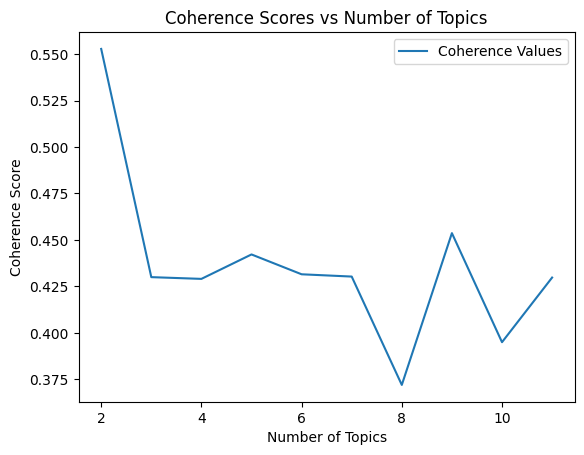

In [38]:
import pandas as pd
from google.colab import files  # Import Colab's files module
import nltk

# Download the stopwords data
nltk.download('stopwords')

def load_data():
    """
    Purpose: Loading a CSV file containing articles using Colab's upload feature
    Output : list of paragraphs/documents and titles
    """
    print("Please upload your CSV file...")
    uploaded = files.upload()  # This will open a file picker dialog

    # Get the file name from the uploaded dictionary
    file_name = next(iter(uploaded))
    print(f"Uploaded file: {file_name}")

    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_name)

    # Check if the 'text' column exists in the CSV
    if 'text' not in df.columns:
        print("Available columns:", df.columns.tolist())
        raise KeyError("Expected column 'text' not found in the CSV file.")

    documents_list = df['text'].tolist()  # List of documents
    titles = [text[:100] for text in documents_list]  # Extracting the first 100 characters of each document for title

    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

# Now call the function to upload and read your data
documents, titles = load_data()

# Preprocessing and other steps
def preprocess_data(doc_set):
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer

    # Initialize tokenizer, stopwords, and stemmer
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))  # Use the stopwords resource
    p_stemmer = PorterStemmer()

    texts = []
    for doc in doc_set:
        raw = doc.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [token for token in tokens if token not in en_stop]
        stemmed_tokens = [p_stemmer.stem(token) for token in stopped_tokens]
        texts.append(stemmed_tokens)

    return texts

# Preprocess the documents
cleaned_docs = preprocess_data(documents)

# Assuming the rest of the code for generating coherence graph is here
def prepare_corpus(doc_clean):
    import gensim
    # Creating the term dictionary of our corpus
    dictionary = gensim.corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, start, stop, step):
    from gensim.models import CoherenceModel
    coherence_values = []
    model_list = []

    for num_topics in range(start, stop, step):
        # Generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def plot_graph(doc_clean, start, stop, step):
    import matplotlib.pyplot as plt
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, start, stop, step)

    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores vs Number of Topics")
    plt.legend(["Coherence Values"], loc='best')
    plt.show()

# Plotting the coherence scores
start, stop, step = 2, 12, 1
plot_graph(cleaned_docs, start, stop, step)


## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [114]:
%%capture
!pip install bertopic

In [11]:
import pandas as pd
from google.colab import files

# Step 1: Upload the file from your local system
uploaded = files.upload()  # This will prompt you to select the file

# Check the uploaded files and print their names
print("Uploaded file names:", uploaded.keys())

# Step 2: Set the correct path to the uploaded file in /content
file_name = list(uploaded.keys())[0]  # Automatically grab the uploaded file

# Step 3: Load the data using pandas
data = pd.read_csv(f'/content/{file_name}')  # Read the CSV file from the /content directory

# Print the first few rows to check the dataset structure and columns
print("First few rows of the dataset:")
print(data.head())

# Print column names to help you identify the text column
print("Column names in the dataset:", data.columns)

# Specify the column name that contains the text data (change from 'author' to 'text')
text_column = 'text'  # This is the column that likely contains the text content

# Step 4: Check if the specified column exists
if text_column not in data.columns:
    print(f"Column '{text_column}' not found. Please check the column names.")
else:
    # Extract documents (remove NaN values)
    docs = data[text_column].dropna().tolist()

    # Now `docs` contains your text data
    print(f"First 5 documents:\n{docs[:5]}")

# Step 5: Use BERTopic for topic modeling
from bertopic import BERTopic

# Initialize the BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

# Fit the model to the documents (ensure 'docs' is defined correctly)
topics, probs = topic_model.fit_transform(docs)

# Print the topics
print("First 5 topics:", topics[:5])

# Print the top words for each topic
for i, topic in enumerate(topic_model.get_topics()):
    print(f"Topic {i}: {topic}")


2024-11-05 05:39:06,542 - BERTopic - Embedding - Transforming documents to embeddings.


Saving articles 3.csv to articles 3 (9).csv
Uploaded file names: dict_keys(['articles 3 (9).csv'])
First few rows of the dataset:
             author claps  reading_time  \
0        Justin Lee  8.3K            11   
1       Conor Dewey  1.4K             7   
2  William Koehrsen  2.8K            11   
3      Gant Laborde  1.3K             7   
4  Emmanuel Ameisen   935            11   

                                                link  \
0  https://medium.com/swlh/chatbots-were-the-next...   
1  https://towardsdatascience.com/python-for-data...   
2  https://towardsdatascience.com/automated-featu...   
3  https://medium.freecodecamp.org/machine-learni...   
4  https://blog.insightdatascience.com/reinforcem...   

                                               title  \
0  Chatbots were the next big thing: what happene...   
1  Python for Data Science: 8 Concepts You May Ha...   
2  Automated Feature Engineering in Python – Towa...   
3  Machine Learning: how to go from Zero to Hero .

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2024-11-05 05:39:59,684 - BERTopic - Embedding - Completed ✓
2024-11-05 05:39:59,686 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-05 05:40:11,370 - BERTopic - Dimensionality - Completed ✓
2024-11-05 05:40:11,373 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-05 05:40:11,403 - BERTopic - Cluster - Completed ✓
2024-11-05 05:40:11,408 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-05 05:40:12,030 - BERTopic - Representation - Completed ✓


First 5 topics: [7, 2, 5, 6, 8]
Topic 0: -1
Topic 1: 0
Topic 2: 1
Topic 3: 2
Topic 4: 3
Topic 5: 4
Topic 6: 5
Topic 7: 6
Topic 8: 7
Topic 9: 8


In [12]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,44,-1_the_to_and_of,"[the, to, and, of, in, is, that, for, we, on]","[Updated April 2018: Uses CUDA 9, cuDNN 7 and ..."
1,0,64,0_the_and_of_to,"[the, and, of, to, in, that, is, it, be, as]",[Artificial Intelligence (AI) is the mantra of...
2,1,54,1_the_to_of_in,"[the, to, of, in, and, is, that, we, it, this]",[Update 25.1.17 — Took me a while but here is ...
3,2,37,2_the_and_to_of,"[the, and, to, of, learning, you, for, machine...","[Over the past 8 months, I’ve been interviewin..."
4,3,34,3_the_of_to_and,"[the, of, to, and, is, image, in, this, rcnn, we]",[The advent of powerful and versatile deep lea...


In [13]:
topic_model.get_topic(0)  # Select the most frequent topic

[('the', 0.05137616050865446),
 ('and', 0.046853584667706186),
 ('of', 0.0458863638779194),
 ('to', 0.045453116992116904),
 ('in', 0.0337753307090605),
 ('that', 0.03322200244244795),
 ('is', 0.02609493096484538),
 ('it', 0.02507122892179237),
 ('be', 0.02388425267512591),
 ('as', 0.02120011101225368)]

In [14]:
topic_model.topics_[:20]

[7, 2, 5, 6, 8, 3, 5, 2, 5, 2, 8, 1, 0, 6, 1, 1, 2, 1, 6, 2]

In [17]:
topic_model.visualize_topics()

In [16]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [15]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [18]:
topic_model.update_topics(docs, n_gram_range=(1, 2))
topic_model.get_topic(0)   # We select topic that we viewed before

[('the', 0.037848766965622095),
 ('and', 0.03196856065935678),
 ('to', 0.031769862290084834),
 ('of', 0.031630035482542056),
 ('in', 0.022259925616074015),
 ('that', 0.02154679203841455),
 ('is', 0.017079872273457523),
 ('it', 0.0159018109467698),
 ('be', 0.01473821359992112),
 ('for', 0.01344995563382102)]

In [19]:
topic_model.reduce_topics(docs, nr_topics=60)
# Access the newly updated topics with:
print(topic_model.topics_)

2024-11-05 05:40:38,271 - BERTopic - Topic reduction - Reducing number of topics
2024-11-05 05:40:38,274 - BERTopic - Topic reduction - Reduced number of topics from 10 to 10


[7, 2, 5, 6, 8, 3, 5, 2, 5, 2, 8, 1, 0, 6, 1, 1, 2, 1, 6, 2, 0, 5, 0, 1, 6, 6, 1, 0, 0, 6, 5, 1, -1, 1, 3, 1, 6, 0, -1, 1, 6, 2, 2, 0, 2, 6, 5, 2, 5, 5, 2, 5, 2, 5, 1, -1, 1, 1, 6, -1, 1, 1, 1, 4, 2, 2, 1, 2, 5, 6, 6, 3, 4, -1, 6, 0, -1, 5, 1, 2, 8, 5, 2, 0, 1, 0, 7, 0, 8, 3, 5, 2, 5, 2, 0, 8, 7, 1, 6, 2, 0, 4, 0, 0, 0, -1, 0, 0, 0, 0, 0, 5, 1, 0, -1, -1, -1, 0, 0, 1, 7, 0, 7, 0, 0, 8, 4, 0, 7, 0, 0, 4, 0, 0, 7, 1, 6, -1, 1, 1, 0, 1, 1, 2, 5, 6, 6, 0, 3, -1, 0, -1, 0, 0, 8, 0, 6, 8, 3, 5, 2, 3, 4, -1, 4, 1, 1, 1, 0, 1, 1, -1, 3, -1, 3, 2, 2, 6, 4, 4, 2, 4, 7, 5, 3, 1, 3, 3, 0, 1, 4, 1, 1, 8, -1, -1, 5, 6, 3, -1, 3, -1, 2, 5, 2, -1, 8, 8, 1, 1, 2, 8, 6, 3, 2, 6, -1, 7, 0, -1, 2, 3, 1, 7, 0, 3, -1, 0, -1, 2, -1, 4, 0, 0, 1, 0, 0, 0, 8, 0, 0, 0, 7, -1, -1, 3, 0, 0, 6, 0, 3, 3, 0, 3, 0, 7, 1, 7, -1, 3, -1, 0, 2, -1, 4, 0, 1, 7, 0, 3, -1, 3, -1, 7, 0, 2, 2, 3, 3, 5, 3, -1, 3, -1, 4, 3, 1, -1, 1, -1, 4, -1, 2, 4, 4, 8, 1, 5, 1, 1, 4, 0, -1, 2, 4, 6, 0, 1, -1, 4, 8, 4, 4, -1, 1, 0, -1, 3, 2, 

In [20]:
# Save model
topic_model.save("my_model")
# Load model
my_model = BERTopic.load("my_model")

2024-11-05 05:40:40,256 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [21]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## **Question 3 (Alternative) - (10 points)**

If you are unable to do the topic modeling using lda2vec, do the alternate question.

Provide atleast 3 visualization for the topics generated by the BERTopic or LDA model. Explain each of the visualization in detail.

I have provided visulizations above for BERT MODEL
The visualizations are generally created by BERTopic, one of the popular methods of topic modeling using embeddings for document clustering into topics. Each is explained in detail below.

1. Intertopic Distance Map
Purpose: This visualization is supposed to show the relations between the topics through their distance in a two-dimensional space. BERTopic commonly uses dimension-reduction techniques like UMAP (Uniform Manifold Approximation and Projection) to project topics this way.
This map displays the topics as circles, and the position of each topic relative to others reflects a topic's similarity to other topics. Topics lying close to each other are similar in content, while topics lying far from each other differ considerably. It can be observed from this map that the cluster of topics is tightly grouped on one side, which would indicate that some topics are quite similar in nature, while others are distinct.
Insights: It helps in finding the clustering of topics of the same nature, and it shows the distribution of the topics. This is good for topic distinctiveness and how much overlap there is between topics.
2. Topic Probability Distribution
Purpose: In this bar chart, it shows the probability distribution of every topic, which essentially gives an idea about the prevalence or importance of each particular topic in the dataset.
Interpretation: Each bar represents one topic, and the length of each bar shows the probability or relative importance of each topic. For example, if Topic 0 has higher probability, it is more dominant in data.
Insights: This topic modeling visual informs us about something with regard to the most outstanding topics within the dataset. These are indicative of the relevant themes or the sets of themes that are most recurrent in the corpus. In this example, it appears that Topic 0 is dominating, while others vary in their saliency.
These are typical outputs from BERTopic, which give insights on the distribution of the topic, the dominance, and the similarity of topics. All together, these help to assess the coherence and relevance of the topics, how the topics would be grouped together, giving a better view of the underlying themes within the dataset.

The figure you have provided is briefly described below.

Image Title: Hierarchical Clustering

Description: This plot displays a dendrogram, a tree-like structure employed in visualizing hierarchical clustering. It looks like some sort of clustering of people or entities, depicted on the left side of the names. The above dendrogram illustrates how these entities are grouped about each other based on similar grounds. The horizontal lines represent distances between clusters. The longer the line, the greater the dissimilarity between the clusters.

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

LDA is a probabilistic generative model that views every document as a mixture of topics, and every topic as a mixture of words.
Latent Semantic Indexing: This is a technique that pinpoint patterns within a document set based on the word-concept relationship.
BERT: Bidirectional Encoder Representations from Transformers are a very powerful language model which can be used for the topic modeling task among other NLP tasks. Key Differences and Strengths Algorithm Strengths Weakness LDA Simple to implement, interpretable topics Relies on bag-of-word, misses information on word order and semantic relationships. LSI Handles big datasets well; good on identifying latent semantic relationships Can be highly sensitive to stop words and common words. BERT Captures semantic and syntactic information; produces more meaningful topics More complex and computationally expensive Export to Sheets
Comparing Performance:

In comparing the performance of these algorithms after considering numerous factors have to be considered.

Topic Coherence:
BERT: In most instances, it produced more coherent and interpretable topics when handling complex datasets.
LDA and LSI: It generated coherent topics, though sometimes they failed in cases of complex datasets or ambiguity of word meaning.
Topic Diversity:
BERT: It can cover diversity of topics, especially while handling diverse and subtle language.
LDA and LSI: These sometimes give too broad or overlapping topics.
Computational Cost:

BERT: This is much more computationally expensive, since the model is so complicated.
LDA and LSI: Computationally less expensive.
Data Quality:

It is clean, well-structured data would be required for appropriate results.
Choosing the Right Algorithm:

What will be the best algorithm in a particular task is determined by several factors:

Dataset size and complexity: BERT would be good in case of large and complex datasets; for smaller and simpler ones, LDA or LSI would work just fine.
Computational Resources: Because of the lack of computational resources, a very realistic alternative could be a choice between LDA or LSI.
Topic Granularity: If finer topics are needed, BERT will do a better job.
Interpretability: If the main priority is interpretability, then it would be better to choose LDA.
In general,

BERT often yields performance significantly higher than more traditional approaches like LDA and LSI, particularly when processing complex and fine-grained data. Unfortunately, its computational cost is high and is a complex framework, so it's not possible to adopt it in many scenarios. LDA and LSI could be helpful in simpler tasks with less data.

For concrete comparison, it would be better to test the performance of these algorithms on your dataset based on metrics like coherence, perplexity, and human evaluation.

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



LDA is a probabilistic generative model that views every document as a mixture of topics, and every topic as a mixture of words.
Latent Semantic Indexing: This is a technique that pinpoint patterns within a document set based on the word-concept relationship.
BERT: Bidirectional Encoder Representations from Transformers are a very powerful language model which can be used for the topic modeling task among other NLP tasks. Key Differences and Strengths Algorithm Strengths Weakness LDA Simple to implement, interpretable topics Relies on bag-of-word, misses information on word order and semantic relationships. LSI Handles big datasets well; good on identifying latent semantic relationships Can be highly sensitive to stop words and common words. BERT Captures semantic and syntactic information; produces more meaningful topics More complex and computationally expensive Export to Sheets
Comparing Performance:

In comparing the performance of these algorithms after considering numerous factors have to be considered.

Topic Coherence:
BERT: In most instances, it produced more coherent and interpretable topics when handling complex datasets.
LDA and LSI: It generated coherent topics, though sometimes they failed in cases of complex datasets or ambiguity of word meaning.
Topic Diversity:
BERT: It can cover diversity of topics, especially while handling diverse and subtle language.
LDA and LSI: These sometimes give too broad or overlapping topics.
Computational Cost:

BERT: This is much more computationally expensive, since the model is so complicated.
LDA and LSI: Computationally less expensive.
Data Quality:

It is clean, well-structured data would be required for appropriate results.
Choosing the Right Algorithm:

What will be the best algorithm in a particular task is determined by several factors:

Dataset size and complexity: BERT would be good in case of large and complex datasets; for smaller and simpler ones, LDA or LSI would work just fine.
Computational Resources: Because of the lack of computational resources, a very realistic alternative could be a choice between LDA or LSI.
Topic Granularity: If finer topics are needed, BERT will do a better job.
Interpretability: If the main priority is interpretability, then it would be better to choose LDA.
In general,

BERT often yields performance significantly higher than more traditional approaches like LDA and LSI, particularly when processing complex and fine-grained data. Unfortunately, its computational cost is high and is a complex framework, so it's not possible to adopt it in many scenarios. LDA and LSI could be helpful in simpler tasks with less data.

For concrete comparison, it would be better to test the performance of these algorithms on your dataset based on metrics like coherence, perplexity, and human evaluation.